In [6]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords

In [12]:
f = open('./data/Dev/INPUT.txt').readlines()
stop_words = set(stopwords.words('english'))
num_of_tweets = 0
lines = []

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def preprocess_tweet(tweet):
    words = tweet.split(' ')
    temp = []
    for w in words:
        s = w.lower()
        if "http" in s or s in stop_words:
            continue
        else:
            temp.append(s)
    return " ".join(temp)

input_tuple = []
input_tweets = []
for line in f:
    num_of_tweets = num_of_tweets+1
    input_id = line.split('\t',2)[0]
    s = line.split('\t',2)[2]
    input_tuple.append((input_id,preprocess_tweet(s)))
    input_tweets.append(preprocess_tweet(s))
    
input_tuple[1:5]

[('801989272341453952',
  'ariana grande kiis fm truly cd listening party burbank #arianagrande\n'),
 ('801990978424962944',
  'ariana grande white house easter egg roll washington #arianagrande\n'),
 ('801996232553963008',
  '#cd #musics ariana grande sweet like candy 3.4 oz 100 ml sealed box 100% authenic new'),
 ('801998343442407040',
  'side side 😘 @arianagrande #sidetoside #arianagrande #musically #comunidadgay #lgbt🌈  #lotb…')]

In [13]:
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import TweetTokenizer

In [14]:
white_tokens = WhitespaceTokenizer().tokenize(" ".join(input_tweets))
tweet_tokens = TweetTokenizer().tokenize(" ".join(input_tweets))
print("Total number of words white: ", len(white_tokens))
print("Total number of words tweet: ", len(tweet_tokens))

Total number of words white:  124923
Total number of words tweet:  153822


In [25]:
from nltk.probability import ConditionalFreqDist
from nltk.probability import FreqDist

tweet_tokens = list(filter (lambda s:any([c.isalnum() for c in s]), tweet_tokens))
white_tokens = list(filter (lambda s:any([c.isalnum() for c in s]), white_tokens))

In [26]:
freq_white = FreqDist(white_tokens)
freq_tweet = FreqDist(tweet_tokens)

In [40]:
#freq_white.most_common(30)

In [39]:
#freq_tweet.most_common(20)

In [36]:
input_tuple_tokens = []
num_of_chars = 0
lchars = []
for tu in input_tuple:
    tokens = WhitespaceTokenizer().tokenize(tu[1])
    tokens = list(filter (lambda s:any([c.isalnum() for c in s]), tokens))
    num_of_chars = num_of_chars + len(tu[1])
    input_tuple_tokens.append((tu[0],tokens))
    
    
print("avg words per tweet: ", len(white_tokens)/len(input_tweets))
print("avg chars per tweet: ", num_of_chars/len(input_tweets))

for token in white_tokens:
    lchars.append(len(token))

print("Avg chars of tokens: ",np.mean(lchars))
print("Std chars of tokens: ",np.std(lchars))

print("Unique words: ", len(set(white_tokens)))
print("Token/Type: ", len(set(white_tokens))/len(white_tokens))

avg words per tweet:  9.901497883425595
avg chars per tweet:  77.4558775643113
Avg chars of tokens:  6.790109348022692
Std chars of tokens:  3.531759688124525
Unique words:  38999
Token/Type:  0.32063635616213104


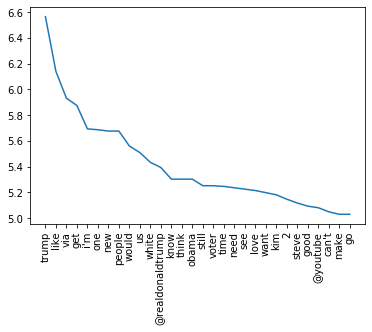

In [38]:
from matplotlib import pyplot as plt
top30 = list(freq_white.most_common(30))
word30 = [t[0] for t in top30]
log30 = [np.log(t[1]) for t in top30]
plt.plot(word30,log30)
plt.xticks(rotation=90)
plt.show()

In [41]:
from nltk import ngrams
n_grams = {}

for n in range(2,6):
    d_n = {}
    for t in input_tweets:
        grams = ngrams(t.split(),n)
        for g in grams:
            if g in d_n:
                d_n[g] = d_n[g]+1
            else:
                d_n[g] = 1
    n_grams[n] = d_n

In [42]:
n_grams_chars = {}
for n in range(2,8):
    d_char = {}
    for b in input_tweets:
        grams = [b[i:i+n] for i in range(len(b)-n+1)]
        for g in grams:
            if g in d_char:
                d_char[g] = d_char[g]+1
            else:
                d_char[g] = 1
        n_grams_chars[n] = d_char

In [43]:
##Combine all the input.
dev = open('./data/Gold/dev.txt').readlines()
devtest = open('./data/Gold/devtest.txt').readlines()
test = open('./data/Gold/test.txt').readlines()
train = open('./data/Gold/train.txt').readlines()

In [45]:
def read_gold_files(f):
    res = []
    for line in f:
        s = line.split('\t',2)
        res.append((preprocess_tweet(s[2]),s[1]))
    return res

gold_tweets = read_gold_files(dev)+read_gold_files(devtest)+read_gold_files(test)+read_gold_files(train)

In [46]:
gold_tweets[1:10]

[('jay z joins instagram nostalgic tribute michael jackson: jay z apparently joined instagram saturday and..',
  'positive'),
 ('michael jackson: bad 25th anniversary edition (picture vinyl): unique picture disc vinyl includes original 1',
  'neutral'),
 ('liked @youtube video one direction singing "man mirror" michael jackson atlanta, ga [june 26,\n',
  'positive'),
 ("18th anniv princess diana's death. still want believe living private island away public. michael jackson.\n",
  'positive'),
 ('@oridaganjazz 1st time heard michael jackson sing honolulu, hawaii @ restaurant radio. a.b.c. 13. loved it!\n',
  'positive'),
 ("'michael jackson' appeared saturday 29 9th place top20 miami's trends: #trndnl\n",
  'neutral'),
 ('old enough remember michael jackson attending grammys brooke shields webster sat lap show?\n',
  'positive'),
 ("@etbowser u enjoy 2nd rate michael jackson bit? honest ques. like can't feel face song god obvious want mj 2.0\n",
  'negative'),
 ('weeknd closest thing ma

In [52]:
def features(tweet):
    tokens = WhitespaceTokenizer().tokenize(tweet)
    tokens = list(filter (lambda s:any([c.isalnum() for c in s]), tokens))
    return dict(('contains(%s)' % w, True) for w in tokens)

from sklearn.model_selection import train_test_split
trains, tests = train_test_split(gold_tweets, test_size = 0.33, random_state=42)

In [53]:
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [54]:
training_features = [(features(tu[0]),tu[1]) for tu in trains]

In [55]:
len(training_features)

20522

In [56]:
sentiment_analyzer = SentimentAnalyzer()
trainer = NaiveBayesClassifier.train
classifier = sentiment_analyzer.train(trainer, training_features)

Training classifier


In [57]:
truth_list = [(features(tu[0]),tu[1]) for tu in tests]

In [58]:
sentiment_analyzer.evaluate(truth_list,classifier)

Evaluating NaiveBayesClassifier results...


{'Accuracy': 0.5701849836779108,
 'Precision [positive]': 0.6412535079513564,
 'Recall [positive]': 0.6880803011292347,
 'F-measure [positive]': 0.6638421498607916,
 'Precision [neutral]': 0.6562291805463024,
 'Recall [neutral]': 0.43268174829782563,
 'F-measure [neutral]': 0.5215089344804764,
 'Precision [negative]': 0.37160014129282937,
 'Recall [negative]': 0.6696371737746658,
 'F-measure [negative]': 0.47796456156292594}

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [76]:
nltk_vader_res = []

analyzer = SentimentIntensityAnalyzer()
sentences = [t[0] for t in tests]
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    if vs['compound'] >= 0.45 : 
        nltk_vader_res.append("positive") 
    elif vs['compound'] <= - 0.45 : 
        nltk_vader_res.append("negative") 
    else : 
        nltk_vader_res.append("neutral")

In [77]:
correct = 0
for i in range(len(sentences)):
    if nltk_vader_res[i] == tests[i][1]: 
        correct = correct+1
correct/len(sentences)

0.5616777129290731

In [78]:
trainingFeatures=nltk.classify.apply_features(features,trains)

In [79]:
NBayesClassifier=nltk.NaiveBayesClassifier.train(trainingFeatures)

In [82]:
NBResultLabels = [NBayesClassifier.classify(tu[0]) for tu in truth_list]

In [84]:
nb = 0
for i in range(len(NBResultLabels)):
    if NBResultLabels[i] == truth_list[i][1]:
        nb = nb+1


0.5701849836779108